In [6]:
#Download Detectron
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tgi2tuuq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tgi2tuuq
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.

In [ ]:
#Importing Libraries
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_pascal_voc
from detectron2 import model_zoo
import os
from detectron2.evaluation import PascalVOCDetectionEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import torch
from detectron2.utils.visualizer import ColorMode, Visualizer
import random
import matplotlib.pyplot as plt
from detectron2.engine.defaults import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import json

In [ ]:
#Create Datasets
register_pascal_voc("voc_train_2007","/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2007","trainval","trainval")
register_pascal_voc("voc_train_2012","/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2012","trainval","trainval")
register_pascal_voc("voc_val_2007","/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2007","test",2007)
# Function to save dataset to JSON
def save_dataset_to_json(dataset_name, file_path):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    with open(file_path, 'w') as f:
        json.dump(dataset_dicts, f)

# Save each Pascal VOC dataset as JSON
save_dataset_to_json("voc_train_2007", "voc_train_2007.json")
save_dataset_to_json("voc_train_2012", "voc_train_2012.json")
save_dataset_to_json("voc_val_2007", "voc_val_2007.json")

# Save category names (thing_classes) from metadata
voc_metadata = MetadataCatalog.get("voc_train_2007")
with open("voc_categories.json", 'w') as f:
    json.dump(voc_metadata.thing_classes, f)

### Faster-RCNN on Pascal (2007+2012)

In [9]:
#Configure the model
cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN=("voc_train_2007","voc_train_2012")
cfg.DATASETS.TEST=("voc_val_2007",) 
cfg.DATALOADER.NUM_WORKERS=2

#Use COCO-pretrained weights
cfg.MODEL.WEIGHTS="detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH=4
cfg.SOLVER.BASE_LR=0.00025
cfg.SOLVER.MAX_ITER=5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE=128
cfg.MODEL.ROI_HEADS.NUM_CLASSES=20

#Output directory
cfg.OUTPUT_DIR="./output_voc"
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)

#Train the model
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


model_final_280758.pkl: 167MB [00:00, 245MB/s]                            
/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OrderedDict([('bbox', {'AP': 56.96253815133404, 'AP50': 82.42943694846625, 'AP75': 64.08752735479933})])


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

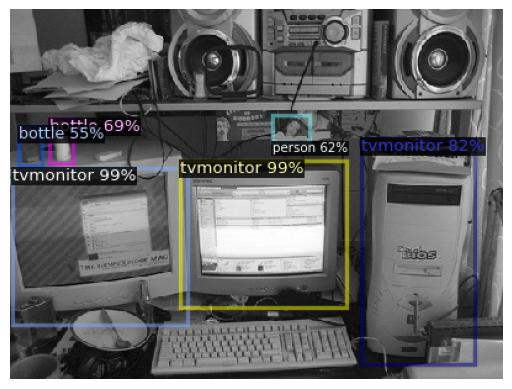

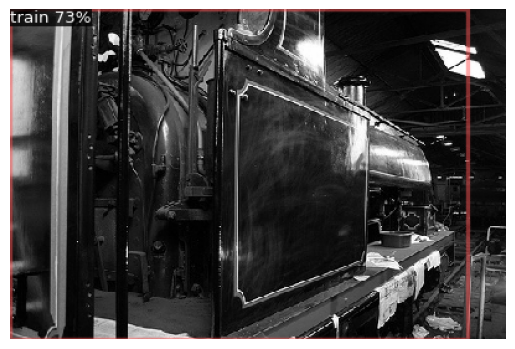

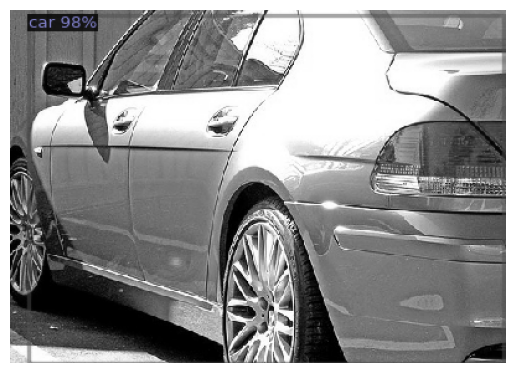

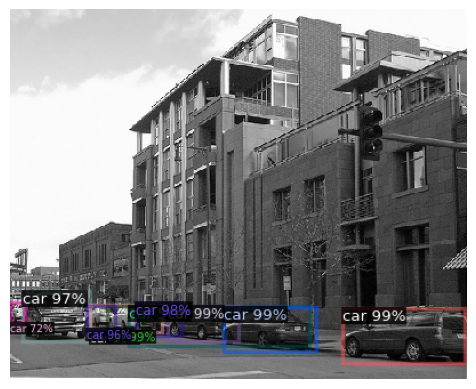

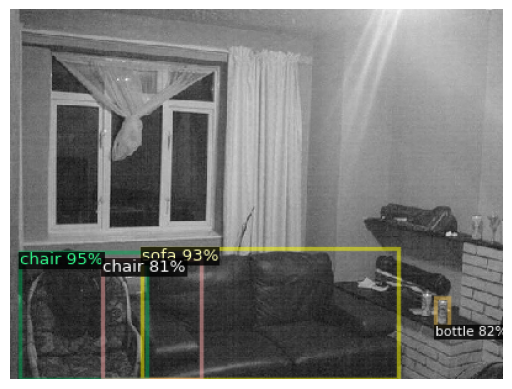

Evaluation images with bounding boxes are saved in: ./output_voc/eval_images


In [20]:
#Evaluate the model
evaluator=PascalVOCDetectionEvaluator("voc_val_2007")
val_loader=build_detection_test_loader(cfg,"voc_val_2007")
print(inference_on_dataset(trainer.model,val_loader,evaluator))

#Load the trained model
cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.5
predictor=DefaultPredictor(cfg)

eval_results_dir="./output_voc/eval_images"
os.makedirs(eval_results_dir,exist_ok=True)

#Visualize predictions on random samples from the validation set
dataset_dicts=DatasetCatalog.get("voc_val_2007")
metadata=MetadataCatalog.get("voc_val_2007")

for d in random.sample(dataset_dicts,5):
    img=cv2.imread(d["file_name"])
    outputs=predictor(img)
    #Draw bounding boxes
    v=Visualizer(img[:,:,::-1],metadata=metadata,scale=0.8,instance_mode=ColorMode.IMAGE_BW)
    v=v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #Save the resulting image with predictions
    result_img_path=os.path.join(eval_results_dir,f"{d['image_id']}_eval.png")
    cv2.imwrite(result_img_path,v.get_image()[:,:,::-1])
    #Display one of the images
    plt.imshow(v.get_image()[:,:,::-1])
    plt.axis("off")
    plt.show()

print("Evaluation images with bounding boxes are saved in:",eval_results_dir)


### RetinaNet on Pascal (2007+2012)

In [22]:
#Configure the model
cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN=("voc_train_2007","voc_train_2012")
cfg.DATASETS.TEST=("voc_val_2007",)
cfg.DATALOADER.NUM_WORKERS=2

#Use COCO-pretrained weights for RetinaNet
cfg.MODEL.WEIGHTS="detectron2://COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl"
cfg.SOLVER.IMS_PER_BATCH=4
cfg.SOLVER.BASE_LR=0.00025
cfg.SOLVER.MAX_ITER=5000
cfg.MODEL.RETINANET.NUM_CLASSES=20 

#Output directory
cfg.OUTPUT_DIR="./output_voc_retinanet"
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)

#Train the model
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


model_final_5bd44e.pkl: 152MB [00:00, 192MB/s]                             
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OrderedDict([('bbox', {'AP': 61.00708208895234, 'AP50': 82.81574397426681, 'AP75': 67.00270770048519})])


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

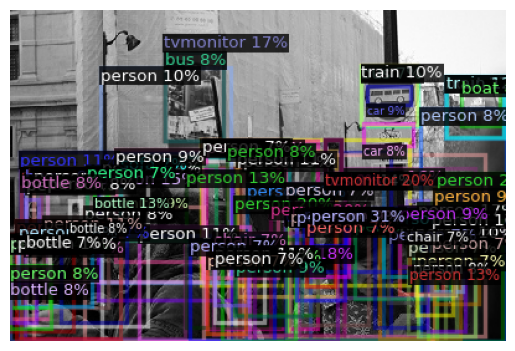

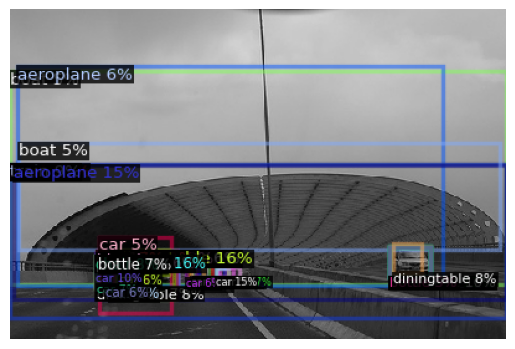

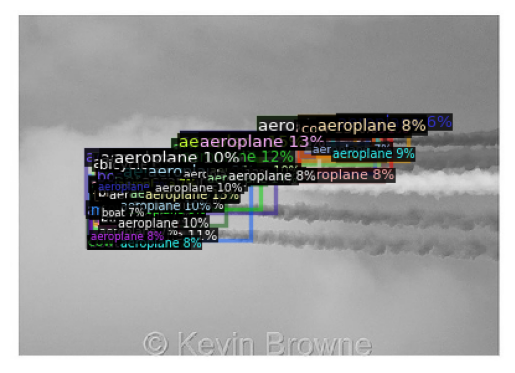

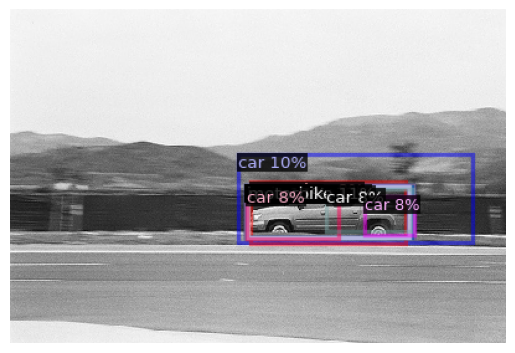

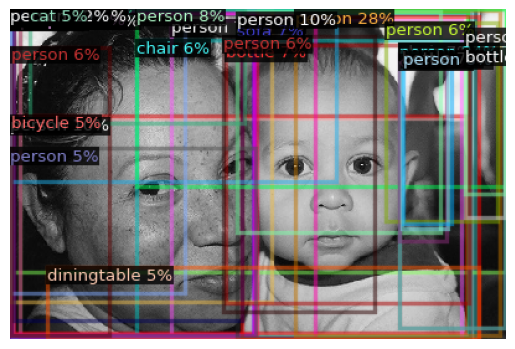

Evaluation images with bounding boxes are saved in: ./output_voc/eval_images_retinanet


In [23]:
#Evaluate the model
evaluator=PascalVOCDetectionEvaluator("voc_val_2007")
val_loader=build_detection_test_loader(cfg,"voc_val_2007")
print(inference_on_dataset(trainer.model,val_loader,evaluator))

#Load the trained model
cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.5
predictor=DefaultPredictor(cfg)

eval_results_dir="./output_voc/eval_images_retinanet"
os.makedirs(eval_results_dir,exist_ok=True)

#Visualize predictions on random samples from the validation set
dataset_dicts=DatasetCatalog.get("voc_val_2007")
metadata=MetadataCatalog.get("voc_val_2007")

for d in random.sample(dataset_dicts,5):
    img=cv2.imread(d["file_name"])
    outputs=predictor(img)
    #Draw bounding boxes
    v=Visualizer(img[:,:,::-1],metadata=metadata,scale=0.8,instance_mode=ColorMode.IMAGE_BW)
    v=v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #Save the resulting image with predictions
    result_img_path=os.path.join(eval_results_dir,f"{d['image_id']}_eval.png")
    cv2.imwrite(result_img_path,v.get_image()[:,:,::-1])
    #Display one of the images
    plt.imshow(v.get_image()[:,:,::-1])
    plt.axis("off")
    plt.show()

print("Evaluation images with bounding boxes are saved in:",eval_results_dir)
